In [40]:
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error #不太靠谱 太劲大求了。差的平方的均值
from sklearn.metrics import explained_variance_score #越小代表结果越差
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score #交叉验证
import matplotlib.pyplot as plt
import matplotlib
from sklearn.tree import DecisionTreeRegressor
import matplotlib.dates as mdate
import tensorflow as tf
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
%matplotlib inline
X = pd.read_excel('./input5.xlsx')
#X['dayofyear'] = X['日期'].apply(lambda x : x.dayofyear)
X['year'] = X['日期'].apply(lambda x : x.year)
X['dayofweek'] =  X['日期'].apply(lambda x: x.dayofweek)
X['dayofmonth'] = X['日期'].apply(lambda x: x.day)
X['前一天供水量'] = X['总供水量'].shift(1)
X['再往前一天供水量'] = X['总供水量'].shift(2)
X['与前一天空气质量差'] = X['空气质量指数'] - X['空气质量指数'].shift(1)
X['与前一天湿度差值'] = X['平均相对湿度'] - X['平均相对湿度'].shift(1)
X['与前一天最低气温差'] = X['最低气温'] - X['最低气温'].shift(1)
X['与前一天最高气温差'] = X['最高气温'] - X['最高气温'].shift(1)
X['与前一天平均温度差'] = X['平均气温'] - X['平均气温'].shift(1)
X = X[~pd.isnull(X['再往前一天供水量'])]
y = X.pop('总供水量')
date = X['日期']
drop = ['日期','星期','24节气','PM2.5','PM10','SO2','CO','NO2','O3_8h']
X.drop(drop,axis = 1,inplace = True)
X_reset = X.reset_index(drop = True)
sunday_index = X_reset.loc[X_reset['节假日'] == '周末'].index
for i in sunday_index:
    if X_reset.loc[i,'dayofweek'] == 6:
         X_reset.loc[i,'节假日'] = '周日'
    if X_reset.loc[i,'dayofweek'] == 5:
         X_reset.loc[i,'节假日'] = '周六'
X_input = pd.get_dummies(X_reset)

In [41]:
y_train = np.float32(y.reshape(964,1))

c:\python3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


In [42]:
inunits =  89
h1_units = 15
W1 = tf.Variable(tf.random_normal([inunits,h1_units],stddev = 0.1),name = 'w1')
b1 = tf.Variable(tf.zeros([h1_units]),name = 'b1')
W2 = tf.Variable(tf.zeros([h1_units,1]),name = 'w2')
b2 = tf.Variable(tf.zeros([1]),name = 'b2')

In [43]:
X = tf.placeholder(tf.float32,[None,inunits],name = 'X')
Y = tf.placeholder(tf.float32,[None,1],name = 'Y')

In [44]:
hidden1 = tf.matmul(X,W1) + b1
y_p = tf.matmul(hidden1,W2) + b2

In [45]:
loss = tf.reduce_mean(tf.reduce_sum(tf.abs(Y - y_p),reduction_indices=[1]))
#先求和（按行求和），然后通过reduction_indices=[1] 将其压扁成一行，然后再求平均

In [46]:
train_step = tf.train.AdagradOptimizer(0.01).minimize(loss)

In [47]:
init=tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
for i in range(100000):
    _,l = sess.run([train_step,loss],feed_dict={X:X_input[:-21].values,Y:y_train[:-21]})

In [54]:
l

95116.35

In [48]:
y_pre = sess.run(y_p,feed_dict={X:X_input[-21:]})

In [51]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate

In [52]:
l

95116.35

111872.25
0.02634195383590568


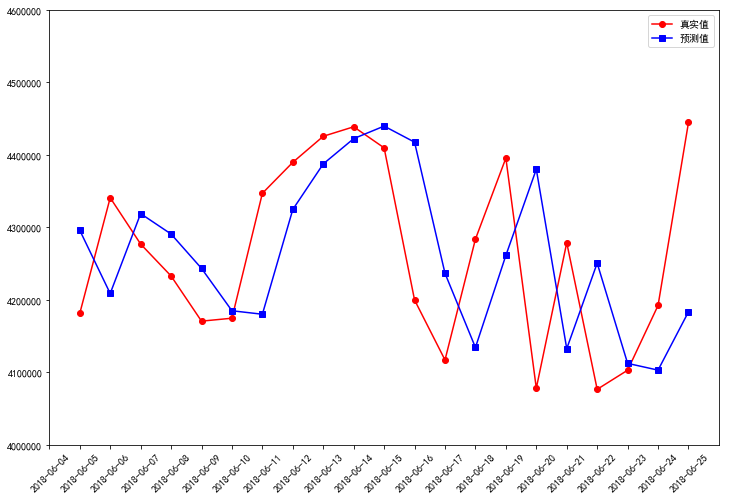

In [53]:
fig1 = plt.figure(figsize=(12,8))
ax1 = fig1.add_subplot(1,1,1) # 一行一列第一块
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))#设置时间标签显示格式
plt.ylim((4000000, 4600000))
#plt.xticks(np.arange(4000000,4600000,5000))
plt.xticks(pd.date_range('2018-06-01','2018-06-25'),rotation = 45)
plt.plot(date[-21:],y[-21:],'-ro',label = '真实值')
plt.plot(date[-21:],y_pre,'-bs',label = '预测值')
plt.legend(loc = 'upper right') 
print(np.mean(abs(y[-21:]-y_pre.reshape(-1))))
print(np.mean(abs(y[-21:]-y_pre.reshape(-1))/y[-21:]))

In [396]:
import tensorflow as tf
import numpy as np
def add_layer(inputs,in_size,out_size,activation_function=None):
    Weights=tf.Variable(tf.random_normal([in_size,out_size]))
    biases=tf.Variable(tf.zeros([1,out_size])+0.1)
    Wx_plus_b=tf.matmul(inputs,Weights)+biases
    if activation_function==None:
        outputs=Wx_plus_b
    else:
        outputs=activation_function(Wx_plus_b)
    return outputs
x_data=np.linspace(-1,1,300)[:,np.newaxis] #300*1,输入只有一个神经元
noise=np.random.normal(0,0.05,x_data.shape)
y_data=np.square(x_data)-0.5+noise
xs=tf.placeholder(tf.float32,[None,1])
ys=tf.placeholder(tf.float32,[None,1])
#定义隐含层,隐含层有10个神经元
l1=add_layer(xs,1,10,activation_function=tf.nn.relu)
#定义输出层,假设没有任何激活函数
prediction=add_layer(l1,10,1,activation_function=None)
loss=tf.reduce_mean(tf.reduce_sum(tf.square(ys-prediction),reduction_indices=[1]))
train_step=tf.train.GradientDescentOptimizer(0.1).minimize(loss)
init=tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(3000):
        sess.run(train_step,feed_dict={xs:x_data,ys:y_data})
        if i%100==0:
            print(sess.run(loss,feed_dict={xs:x_data,ys:y_data}))

0.72740954
0.0127105815
0.008666841
0.006682251
0.005678601
0.004834223
0.004115295
0.0035899114
0.0032549077
0.0030477417
0.0029279082
0.0028486515
0.0027892673
0.002744263
0.002707633
0.0026759342
0.0026496614
0.0026275234
0.0026099947
0.002594592
0.0025791875
0.0025676603
0.0025575878
0.002548677
0.002540735
0.0025325068
0.0025256793
0.0025197596
0.0025145425
0.0025099004


In [397]:
a = tf.constant([[1],[2],[3]])
b = tf.constant([[4],[5],[6]])
c = tf.reduce_mean(tf.abs(a - b))

In [398]:
se = tf.Session()

In [2]:
import numpy as np

In [3]:
z = np.array([[1, 2, 3, 4],
          [5, 6, 7, 8],
          [9, 10, 11, 12],
          [13, 14, 15, 16]])
z.shape

(4, 4)

In [13]:
z.reshape(2,-1)

array([[ 1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16]])

In [32]:
a = np.array([[1,2],[1,2],[3,4]])
b = np.unique(a.view(),'rows',"stable")

In [34]:
b

(array([1, 2, 3, 4]),
 array([0, 1, 4, 5], dtype=int64),
 array([0, 1, 0, 1, 2, 3], dtype=int64))

In [58]:
a = {'a':1}
for key,values in dict.items(a):
    print(key,values)

a 1


In [59]:
dict.items(a)

dict_items([('a', 1)])